In [14]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
from fast_histogram import histogram2d
import seaborn as sn
import h5py

# Converting calorimeter input to 2D histogram images

This script creates calorimeter images based on the calorimeter data from the ATLAS Open jet reconstruction data. 

In [15]:
MIN_RES = 20

#filename = "ttbar_13TeV_taus_10000events"
#rootfile = "/disk/atlas3/data_MC/delphes/ttbar_13TeV_taus_10000events.root:Delphes" 

filename = "directW_13TeV_taus_10000events"
rootfile = "/disk/atlas3/data_MC/delphes/directW_13TeV_taus_10000events.root:Delphes" 

savepath = "/disk/atlas3/data_MC/delphes"

RESOLUTION = int(4*MIN_RES)
MAX_EVENTS = 10000

Using the with uproot loop, we can extract only the data we need and then close the original file. This will save us memory space.

In [16]:
#Load relevant data
def load_data(rootfile:str, branch:str, keys:list):
    with uproot.open(rootfile) as file:
        valid_list = [key in file.keys() for key in keys]
        if valid_list:
            arr = file[branch].arrays(keys, library="ak", how="zip")
            return arr[branch]
        else:
            print(keys[not(valid_list)], " not present in data.")

clusters = load_data(rootfile, "Tower", ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad"])

We create the histograms by using the [fast-histogram library](https://pypi.org/project/fast-histogram/), which is 20-25 x faster than numpy.histogram2d. It does not support advanced binning however, so we perform a simple binning equal to the desired resolution of the image. 

In [17]:
#@nb.jit #could be optimized by using Numba, however 2d histogram is not straightforward to implement
def create_histograms(x, y, z):
    max_available_events = len(x)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    
    Cal = [histogram2d(x[i], y[i], 
            range=[[-np.pi, np.pi], [-5, 5]], bins=RESOLUTION, 
            weights=z[i]) 
            for i in range(0, max_events)]
            
    return Cal


hists = create_histograms(clusters.Phi, clusters.Eta, clusters.ET)

Remember that python histograms produce images with input 2 (eta) on the x-axis and input 1 (phi) on the y-axis.

[Text(0.5, 0, 'Tower transverse energy'),
 (0.0, 6.055310249328613),
 (0.0, 25.0)]

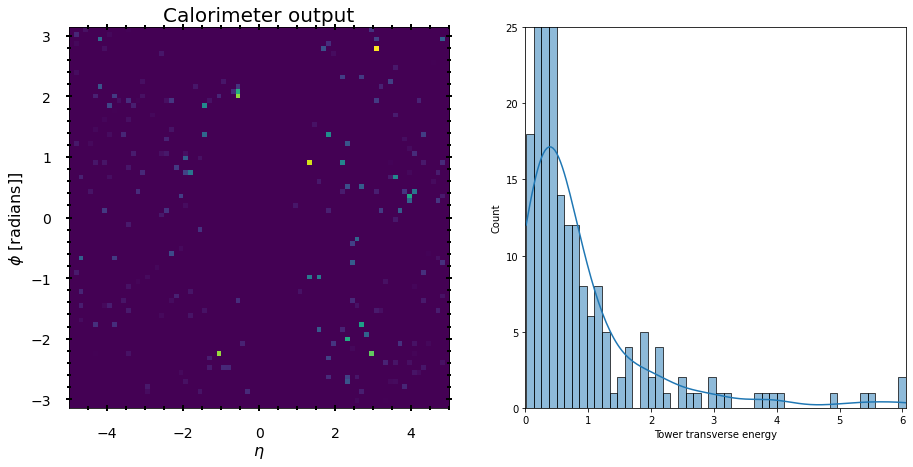

In [18]:
k = np.random.randint(0, high=len(hists)) #a random image
ET = ak.to_list(clusters.ET[k])
def cal_image_plot(ax):
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    ax.set_title("Calorimeter output", fontsize=20, color="black")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 7))
cal_image_plot(axs[0])
axs[0].imshow(hists[k], extent=[-5, 5, -np.pi, np.pi], aspect='auto')
sn.histplot(ET, ax = axs[1], bins=50, kde=True, stat="count")
axs[1].set(xlabel="Tower transverse energy", xlim=[0, max(ET)], ylim = [0, 25])

In [19]:
def store_many_hdf5(images, savepath, filename, labels=None):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File(f"{savepath}/{filename}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    if(labels is not None):
        meta_set = file.create_dataset(
            "meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

store_many_hdf5(hists, savepath, filename)